In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# To check what the column names and types are for the measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
# To check what the column names and types are for the station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last data point in the database is {last_date}")
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
last_year = (last_date - dt.timedelta(days=365)).strftime("%Y-%m-%d")
print(f"A year before the last data point is {last_year}")

The last data point in the database is 2017-08-23
A year before the last data point is 2016-08-23


In [40]:
# Perform a query to retrieve the data and precipitation scores
prcp_results=(session.query(Measurement.date,Measurement.prcp)
             .filter(Measurement.date >= last_year).order_by(Measurement.date).all())

In [41]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=["Date", "Precipitation"])
# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date").dropna().set_index("Date")

/Users/jpot/opt/anaconda3/envs/pythondata/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


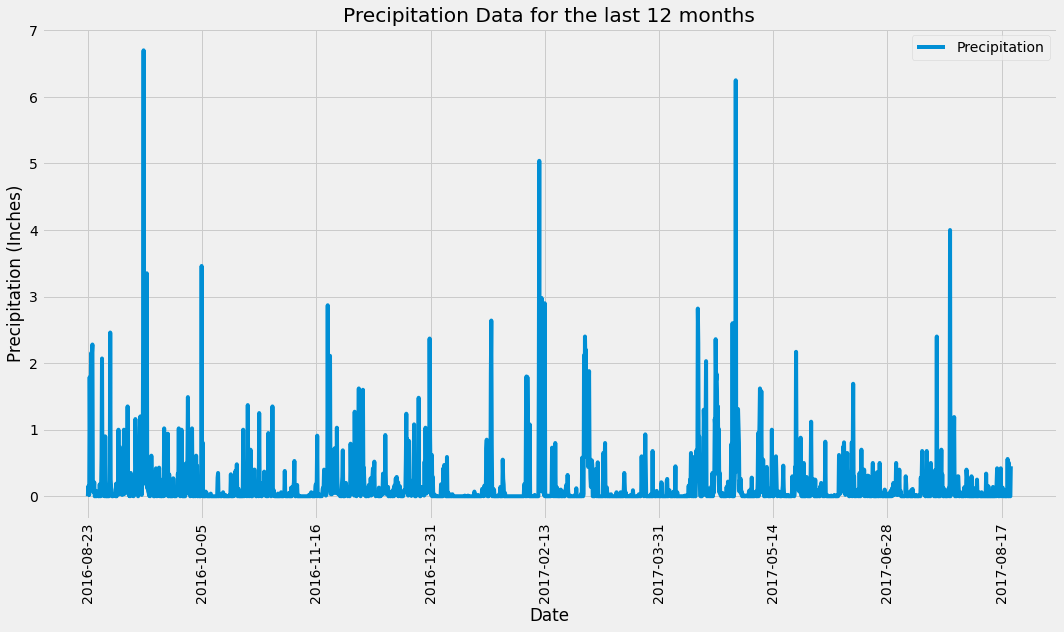

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90,figsize=(15,9))
plt.title("Precipitation Data for the last 12 months")
plt.ylabel("Precipitation (Inches)")
plt.tight_layout()
plt.savefig("Images/prcp_analysis.png")

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [44]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
print(f"There are {stations_count} stations.")

There are 9 stations.


In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(func.count(Measurement.id), Station.station, Station.name)
                  .filter(Measurement.station==Station.station)
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.id).desc()).all())
print(f"The most active stations are:")
pprint(active_stations)

The most active stations are:
[(2772, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (2724, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2709, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (2669, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (2612, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 (2202, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (1979, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (1372, 'USC00517948', 'PEARL CITY, HI US'),
 (511, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US')]


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_record = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
                 .filter(Measurement.station=="USC00519281").all())
print(f"The most active station is {active_stations[0][1]} - {active_stations[0][2]}. The following records show:")
print(f"Lowest temperature: {station_record[0][0]}")
print(f"Highest temperature: {station_record[0][1]}")
print(f"Average temperature: {round(station_record[0][2])}")

The most active station is USC00519281 - WAIHEE 837.5, HI US. The following records show:
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 72


In [47]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp_results = (session.query(Measurement.date, Measurement.tobs)
               .filter(Measurement.date > last_year)
               .filter(Measurement.station=="USC00519281")
               .order_by(Measurement.date).all())
# Convert query into DataFrame
temp_df = pd.DataFrame(temp_results)
temp_df = temp_df.set_index("date").sort_index(ascending=True)

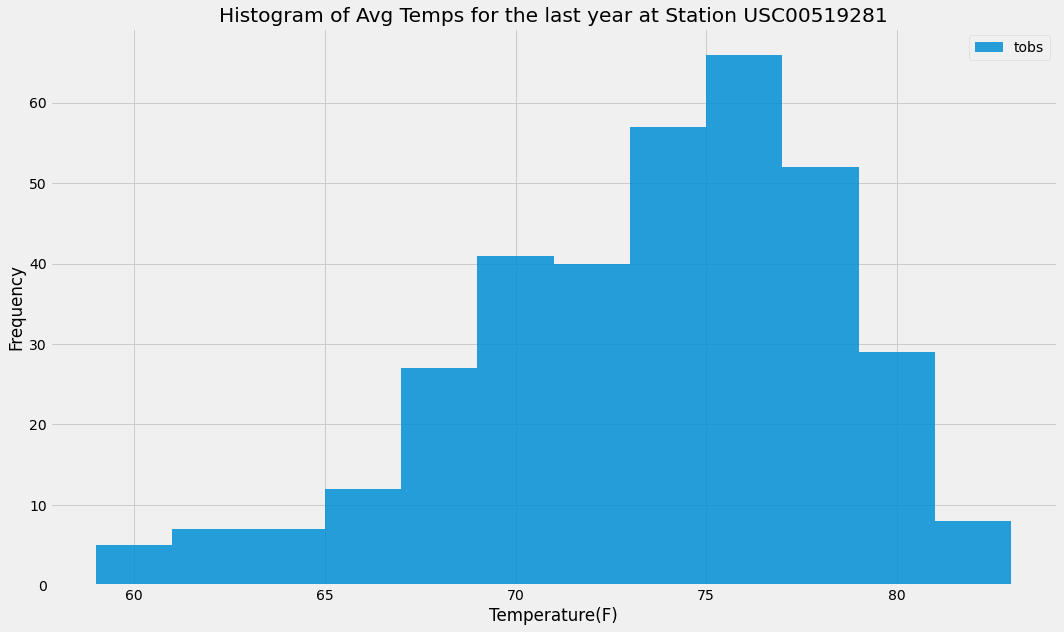

In [48]:
# Plot the results as a histogram
temp_df.plot(kind="hist", bins=12, alpha=.85, figsize=(15,9))
plt.title("Histogram of Avg Temps for the last year at Station USC00519281")
plt.xlabel("Temperature(F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("Images/tobs_histogram.png")